# Property Map Collective Variable Force Field Correction Pipeline
---
The pipeline generates force field corrections in .pdb format and is divided into these steps:

1. [Molecule shape processing](#1.-Molecule-shape-processing)
2. [Preparation of environment and molecule](#2.-Preparation-of-environment-and-molecule)
3. [Generation of representative configurations](#3.-Generation-of-representative-configurations)
4. [Accurate energy computation](#4.-Accurate-energy-computation)
5. [Inaccurate energy computation](#5.-Inaccurate-energy-computation)
6. [Define correction of force field](#6.-Define-correction-of-force-field)

In [1]:
import os
import re
import sys
import math
import time
import shutil
import subprocess

# import analytical software
from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem
from tqdm.notebook import tqdm
from molvs import Standardizer
import nglview as nv
import pytraj as pt
import matplotlib.pyplot as plt

# import custom libraries
from modules.draw_3d import drawit
from modules.k8s.k8s_run import gmx_run, orca_run, parmtsnecv_run, parallel_wait

# path to orca job result check script
orca_job_check = '/opt/orcajobcheck.py'

In [2]:
# XXX: uff, ugly hack to avoid write-to-readonly-file errors
from modules.k8s.config import Config as k8config
!cp {k8config.PICKLE_PATH}/lock.pkl /tmp
k8config.PICKLE_PATH = '/tmp'

In [3]:
# set visualization parameters
# ... add Indices to molecule image
IPythonConsole.drawOptions.addAtomIndices = True

# ... set molecule size
IPythonConsole.molSize = 900,900

In [5]:
# convert Amber parameters to Gromacs format

!python3.9 /opt/conda/envs/pyenv/bin/acpype -p auranofin.prmtop -x auranofin.inpcrd

| ACPYPE: AnteChamber PYthon Parser interfacE v. 2022.6.6 (c) 2023 AWSdS |
Converting Amber input files to Gromacs ...
==> Writing GROMACS files

==> Disambiguating lower and uppercase atomtypes in GMX top file, even if identical.

==> Writing GMX dihedrals for GMX 4.5 and higher.

Total time of execution: less than a second


In [ ]:
# convert to PDB to be loaded into RDKit

t = pt.load('auranofin.amb2gmx/auranofin_GMX.gro',top='auranofin.amb2gmx/auranofin_GMX.top')
t.save('auranofin.pdb')

In [4]:
mol = Chem.RWMol(Chem.MolFromPDBFile('auranofin.pdb',removeHs=False))

In [5]:
natoms=len(mol.GetAtoms())

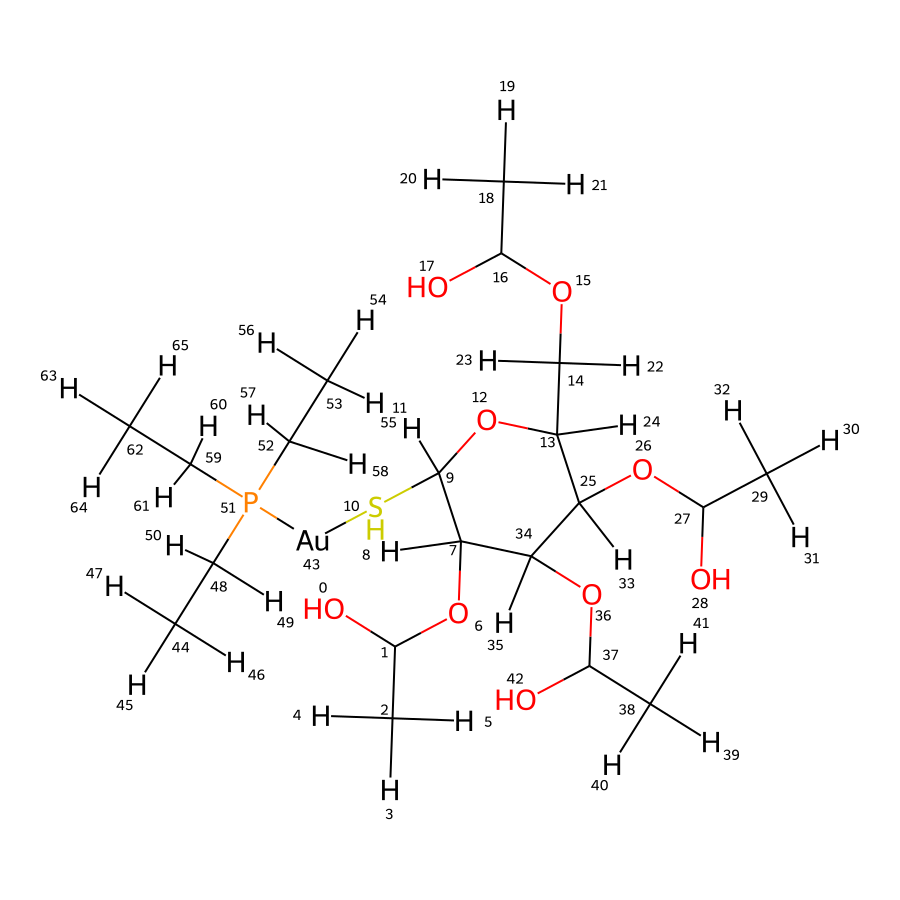

In [6]:
# XXX: add S-Au-P bonds manually

mol.AddBond(10,43)
mol.AddBond(43,51)

# cleanup and recalculation of 2D representation
Chem.SanitizeMol(mol,Chem.rdmolops.SanitizeFlags.SANITIZE_ALL)
Chem.AllChem.Compute2DCoords(mol)

mol

In [24]:
!mkdir -p em
!cp auranofin.amb2gmx/auranofin_GMX.gro auranofin.amb2gmx/auranofin_GMX.top em/

In [ ]:
# prepare and run in-vacuo minimization

gmx_run('editconf -f auranofin_GMX -o box -c -box 3 3 3', workdir='em')

In [ ]:
gmx_run('grompp -f em.mdp -c box -p auranofin_GMX -o em1', workdir='em')

In [ ]:
gmx_run('mdrun -deffnm em1', workdir='em')

### 2.2 Perform molecular dynamics simulation
Create config file and perform molecular dynamics simulation. Simulation trajectory can be visualized.

Afterwards a [periodic boundary conditions](https://www.gromacs.org/Documentation_of_outdated_versions/Terminology/Periodic_Boundary_Conditions) must be applied so the molecule "does not jump out of the box". 

In [7]:
with open('md/md.mdp', 'w') as mdfile:
    lines = [
        'integrator          = sd',
        'nsteps              = 100000',
        'dt                  = 0.001',
        'nstxout             = 1000',
        'nstvout             = 1000',
        'nstenergy           = 1000',
        'nstlog              = 1000',
        'continuation        = no',
        'constraints         = none',
        'cutoff-scheme       = Verlet',
        'ns_type             = grid',
        'nstlist             = 1',
        'rlist               = 1.4',
        'rcoulomb            = 1.4',
        'rvdw                = 1.4',
        'coulombtype         = cut-off',
        'tcoupl              = V-rescale',
        'tc-grps             = system',
        'tau_t               = 0.1',
        'ref_t               = 300',
        'pcoupl              = no',
        'pbc                 = xyz',
        'gen_vel             = yes',
        'epsilon-r           = 80'
    ]
    mdfile.writelines(line + '\n' for line in lines)
    
shutil.copy('em/em1.gro', 'md/')
shutil.copy('auranofin.amb2gmx/auranofin_GMX.top', 'md/')

'md/auranofin_GMX.top'

In [ ]:
gmx_run('grompp -f md.mdp -c em1 -p auranofin_GMX -o md1', workdir='md')

In [ ]:
gmx_run('mdrun -deffnm md1', workdir='md')

In [ ]:
# convert trajectory to .pdb format so it can be visualized

# select group for trjconv evaluation output
# Group     0 (         System)
# Group     1 (          Other)
# Group     2 (            MOL)
group = '0'


gmx_run('trjconv -pbc nojump -s md1.tpr -f md1.trr -o outTraj.pdb', workdir='md', groups=group)

In [11]:
# visualize the molecular dynamics trajectory
# (currently broken)
traj = pt.load('md/outTraj.pdb')
view = nv.show_pytraj(traj)
view

NGLWidget(max_frame=100)

In [7]:
# detect rotatable bonds and corresponding representative torsions (dihedrals)

bond_smarts = ''.join(('[!$([NH]!@C(=O))&!D1&!$(*#*)&!$([C;H3])&!$([O;H1])&!$([N;H3])]-&!@',
                       '[!$([NH]!@C(=O))&!D1&!$(*#*)&!$([C;H3])&!$([O;H1])&!$([N;H3])]'))

rotatable_bond = Chem.MolFromSmarts(bond_smarts)
rotatables = mol.GetSubstructMatches(rotatable_bond)
print(f'Rotatables: {rotatables}')

neigh = { a.GetIdx() : set() for a in mol.GetAtoms() }
for b in mol.GetBonds():
    if b.GetEndAtom().GetAtomicNum() > 1:
        neigh[b.GetBeginAtomIdx()].add(b.GetEndAtomIdx())
    if b.GetBeginAtom().GetAtomicNum() > 1:
        neigh[b.GetEndAtomIdx()].add(b.GetBeginAtomIdx())
    
    
torsions = [ ((neigh[r[0]]-{r[1]}).pop(), r[0], r[1], (neigh[r[1]]-{r[0]}).pop()) for r in rotatables]

print(f'Torsions: {torsions}')

Rotatables: ((1, 6), (6, 7), (9, 10), (13, 14), (14, 15), (15, 16), (25, 26), (26, 27), (34, 36), (36, 37), (48, 51), (51, 52), (51, 59))
Torsions: [(0, 1, 6, 7), (1, 6, 7, 9), (12, 9, 10, 43), (25, 13, 14, 15), (13, 14, 15, 16), (14, 15, 16, 17), (34, 25, 26, 27), (25, 26, 27, 28), (25, 34, 36, 37), (34, 36, 37, 42), (44, 48, 51, 59), (48, 51, 52, 53), (48, 51, 59, 62)]


In [8]:
# auranofin hack (can't do SMARTS now)
torsions.append((9,10,43,51))
torsions.append((10,43,51,52))
torsions

[(0, 1, 6, 7),
 (1, 6, 7, 9),
 (12, 9, 10, 43),
 (25, 13, 14, 15),
 (13, 14, 15, 16),
 (14, 15, 16, 17),
 (34, 25, 26, 27),
 (25, 26, 27, 28),
 (25, 34, 36, 37),
 (34, 36, 37, 42),
 (44, 48, 51, 59),
 (48, 51, 52, 53),
 (48, 51, 59, 62),
 (9, 10, 43, 51),
 (10, 43, 51, 52)]

In [ ]:
# fix eventual periodic boundaries errors 

# select group for trjconv evaluation output
# Group     0 (         System)
# Group     1 (          Other)
# Group     2 (            MOL)
group = '1'

for i in range(len(torsions)):
    fr = str(float(100-len(torsions)+i)-0.01)
    to = str(float(100-len(torsions)+i)+0.01)
    gmx_run(f'trjconv -pbc nojump -s md1 -f md1 -o frame{i}.gro -b {fr} -e {to}<<EOF\n0\nEOF',
            workdir='md',
            groups=group)

In [120]:
# Prepare and run replica exchange metadynamics with a single earlier determined
# rotatable torsion as a CV of each replica. 
# This yields a fairly exhaustive sampling of the conformational space given
# by those torsions while still keeping the structures reasonable


with open('mtd/mtd.mdp', 'w') as mtdfile:
    lines = [
        'integrator          = sd',
        'nsteps              = 10000000',
        'dt                  = 0.001',
        'nstxout             = 10000',
        'nstvout             = 10000',
        'nstenergy           = 1000',
        'nstlog              = 1000',
        'continuation        = no',
        'constraints         = none',
        'cutoff-scheme       = Verlet',
        'ns_type             = grid',
        'nstlist             = 1',
        'rlist               = 1.4',
        'rcoulomb            = 1.4',
        'rvdw                = 1.4',
        'coulombtype         = cut-off',
        'tcoupl              = V-rescale',
        'tc-grps             = system',
        'tau_t               = 0.1',
        'ref_t               = 300',
        'pcoupl              = no',
        'pbc                 = xyz',
        'gen_vel             = yes',
        'epsilon-r           = 80'
    ]
    mtdfile.writelines(line + '\n' for line in lines)

In [132]:
for i in range(len(torsions)):
    if not os.path.exists(f'mtd/w{i}'):
        os.mkdir(f'mtd/w{i}')
        
    with open(f'mtd/w{i}/plumed.dat', "w") as plumeddat:
        plumeddat.write('RANDOM_EXCHANGES\n' +
                       f'WHOLEMOLECULES ENTITY0=1-{natoms}\n')
        for j in range(len(torsions)):
            line = f"TORSION ATOMS={','.join([str(a+1) for a in torsions[j]])} LABEL=cv{j+1}\n"
            plumeddat.write(line)
        line = ' '.join((f'METAD ARG=cv{i+1} HEIGHT=0.5 SIGMA=0.3 PACE=1000 GRID_MIN=-pi',
                         'GRID_MAX=pi BIASFACTOR=15 LABEL=be\n'))
        plumeddat.write(line)
        cvs = ""
        for j in range(len(torsions)):
            cvs = cvs + f'cv{j+1},'
        cvs = cvs[:-1]
        plumeddat.write(f'PRINT ARG={cvs} STRIDE=1000 FILE=COLVAR\n' +
                         'PRINT ARG=be.bias STRIDE=1000 FILE=BIAS\n')

In [ ]:
shutil.copy('auranofin.amb2gmx/auranofin_GMX.top', 'mtd/')

for i in range(len(torsions)):
    shutil.copy(f'md/frame{i}.gro', f'mtd/w{i}/')
    gmx_run(f'grompp -f mtd.mdp -c w{i}/frame{i} -p auranofin_GMX -o w{i}/mtd1',
            workdir='mtd',
            parallel=True)
parallel_wait()

In [ ]:
directories = ''
for i in range(len(torsions)):
    directories = directories + f'w{i} '


gmx_run(f'mdrun -g mdrunlog -deffnm mtd1 -replex 500 -plumed plumed.dat -multidir {directories}', 
        workdir='mtd', 
        mpi_run=len(torsions))

job.batch/gromacs-mdrun-rdtscp-16849311809275584 created


Waiting for job(s) with label gromacs-mdrun-rdtscp-16849311809275584
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


### 3.2 Configurations clustering
Concatinate all the trajectories that simulation produced. Then cluster this trajectory to groups for which one representative configuration is chosen (*cutoff* can be modified for more/less clusters).

Result of [Gromacs clustering](https://manual.gromacs.org/documentation/current/onlinehelp/gmx-cluster.html) is .pdb file containing all representative configurations. These must be divided into separate .pdb files for further processing.

In [56]:
trajectories = ''
for i in range(len(torsions)):
    trajectories = trajectories + f'mtd/w{i}/mtd1.trr '

# concatinate trajectories    
gmx_run(f'trjcat -f {trajectories} -cat -o mtd/mtd1.trr')

# make index file with non-hydrogen atoms
gmx_run("make_ndx -f md/md1.tpr -o mtd/index.ndx", make_ndx="1&!aH*")

job.batch/gromacs-trjcat-rdtscp-16851139635512874 created


Waiting for job(s) with label gromacs-trjcat-rdtscp-16851139635512874
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx trjcat, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-make-ndx-rdtscp-16851139967086346
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx make_ndx, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

In [57]:
# select groups for cluster evaluation output
# Group     0 (         System)
# Group     1 (          Other)
# Group     2 (            MOL)
# Group     3 (         Custom)

groups = '50'
#groups = '30'

gmx_run('''cluster -method gromos -f mtd/mtd1.trr -s mtd/w0/mtd1.tpr -n mtd/index.ndx -cutoff 0.15 \
           -cl clustering/outClusters.pdb''', groups=groups)

job.batch/gromacs-cluster-rdtscp-16851140447372031 created


Waiting for job(s) with label gromacs-cluster-rdtscp-16851140447372031
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx cluster, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

In [58]:
# divide all clusters from clustering output file 
# to single files and index them from 0.
# Also fix missing element of each ATOM on 
# line 77 (by pdb format specification)
cluster_index = 0
i = 0

with open('clustering/outClusters.pdb') as infile:
    clusters = infile.readlines()
    while i < len(clusters):
        with open(f'clustering/outClustersPDB/outCluster{cluster_index}.pdb', 'w') as outfile:
            for line in clusters[i:]:
                split_line = line.split()
                if split_line[0] == 'ATOM':
                    line = line[:77] + split_line[2][0] + '\n'
                outfile.write(line)
                i += 1
                if line == 'ENDMDL\n':
                    break
            cluster_index += 1

### 3.3 Visualize landmarks
Goal of this part is to compute embeddings which are visualized afterwards. Each step is performed on the trajectory which results from previous step. Base trajectory used in 1st step is the concatinated trajectory from metadynamics simulation.

1. Apply periodic boundary conditions to metadynamics trajectory
2. Perform fitting on the trajectory
3. Remove Hydrogen
4. Train [parmtSNEcv](https://gitlab.ics.muni.cz/spiwokv/parmtSNEcv)
5. Compute embeddings

Finally visualize all generated configurations from metadynamics trajectory in contrast to representative clusters configurations

In [59]:
# Group     0 (         System)
# Group     1 (          Other)
# Group     2 (            MOL)
# Group     3 (         Custom)
# select group for periodic boundaries check output:
group = '0'
gmx_run('trjconv -f mtd/mtd1.trr -s mtd/w0/mtd1.tpr -pbc mol -o visualization/traj/mtd1_nopbc.xtc', groups=group)

job.batch/gromacs-trjconv-rdtscp-16851142276367471 created


Waiting for job(s) with label gromacs-trjconv-rdtscp-16851142276367471
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx trjconv, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

In [60]:
# select groups for fitting and output:
groups = '00'
#gmx_run('''trjconv -f visualization/traj/mtd1_nopbc.xtc -s clustering/outClustersPDB/outCluster0.pdb \

gmx_run('''trjconv -f visualization/traj/mtd1_nopbc.xtc -s mtd/w0/mtd1.tpr \
           -fit rot+trans -o visualization/traj/mtd1_fit.xtc''', groups=groups)

job.batch/gromacs-trjconv-rdtscp-16851142393054013 created


Waiting for job(s) with label gromacs-trjconv-rdtscp-16851142393054013
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx trjconv, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

In [61]:
# select group for no Hydrogen output:
#group = '3'
group = '5'
gmx_run('trjconv -f visualization/traj/mtd1_fit.xtc -n mtd/index.ndx -o visualization/traj/mtd1_fit_noH.xtc',
        groups=group)

job.batch/gromacs-trjconv-rdtscp-16851142534389272 created


Waiting for job(s) with label gromacs-trjconv-rdtscp-16851142534389272
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx trjconv, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

In [62]:
# select groups for size of the box and output:
#groups = '33'
groups = '55'
gmx_run('''editconf -f clustering/outClustersPDB/outCluster0.pdb -n mtd/index.ndx -box 3 3 3 -c \
           -o visualization/ref.pdb''', groups=groups)

job.batch/gromacs-editconf-rdtscp-16851142627652664 created


Waiting for job(s) with label gromacs-editconf-rdtscp-16851142627652664
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

In [63]:
# fix weights of atoms
data = ''
with open('visualization/ref.pdb', 'r') as infile:
    data = infile.read()
    data = data.replace('0.00', '1.00')
with open('visualization/ref.pdb', 'w') as outfile:
    outfile.writelines(data)

In [64]:
# train parmtSNEcv
parmtsnecv_run('''parmtSNEcv -i traj/mtd1_fit_noH.xtc -p ref.pdb -boxx 3 -boxy 3 -boxz 3 \
               -dim 2 -layers 2 -o out.txt -plumed plumed.dat -epochs 500''', workdir='visualization')
#               -dim 2 -layers 2 -o out.txt -plumed plumed.dat -epochs 2000''', workdir='visualization')

job.batch/parmtsnecv-parmtsnecv-rdtscp-16851142741354544 created


Waiting for job(s) with label parmtsnecv-parmtsnecv-rdtscp-16851142741354544
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


Using TensorFlow backend.
2023-05-26 15:18:17.437590: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-05-26 15:18:17.464641: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2794650000 Hz
2023-05-26 15:18:17.468576: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x559bef9a2c60 executing computations on platform Host. Devices:
2023-05-26 15:18:17.468605: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
Loading trajectory
Fitting trajectory
<mdtraj.Trajectory with 7670 frames, 32 atoms, 3 residues, and unitcells> succesfully loaded and fitted

box size set to  3.000 x  3.000 x  3.000 nm

Building model
Training model
Computing pairwise distances...
Computing P-values for point 0 of 7670...
Computing P-values for point 500 of 7670...
Computing P-values for point 1000 of 7670...
Computing P-values f

In [65]:
# modify plumed.dat to compute embedding in every step (100->1) 
# and change the name of file for *** mtd trajectory ***
with open('visualization/plumed.dat', 'r') as infile:
    data = infile.read()
    data = data.replace('STRIDE=100', 'STRIDE=1')
    data = data.replace('COLVAR', '2d_embedding')
with open('visualization/plumed.dat', 'w') as outfile:
    outfile.writelines(data)

In [66]:
# run with plumed
gmx_run('driver --plumed plumed.dat --mf_xtc traj/mtd1_fit.xtc', workdir='visualization')

job.batch/gromacs-driver-rdtscp-1685116052950987 created


Waiting for job(s) with label gromacs-driver-rdtscp-1685116052950987
Waiting for 1 jobs to complete
Using namespace mff-prod-ns
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [67]:
# modify plumed.dat to compute embedding in every step and change name of file for *** representatives ***
with open('visualization/plumed.dat', 'r') as infile:
    data = infile.read()
    data = data.replace('2d_embedding', 'landmarks')
with open('visualization/plumed.dat', 'w') as outfile:
    outfile.writelines(data)

In [68]:
# run with plumed
shutil.copy('clustering/outClusters.pdb', 'visualization/')
gmx_run('driver --plumed plumed.dat --mf_pdb outClusters.pdb', workdir='visualization')

job.batch/gromacs-driver-rdtscp-16851161024296381 created


Waiting for job(s) with label gromacs-driver-rdtscp-16851161024296381
Waiting for 1 jobs to complete
Using namespace mff-prod-ns
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



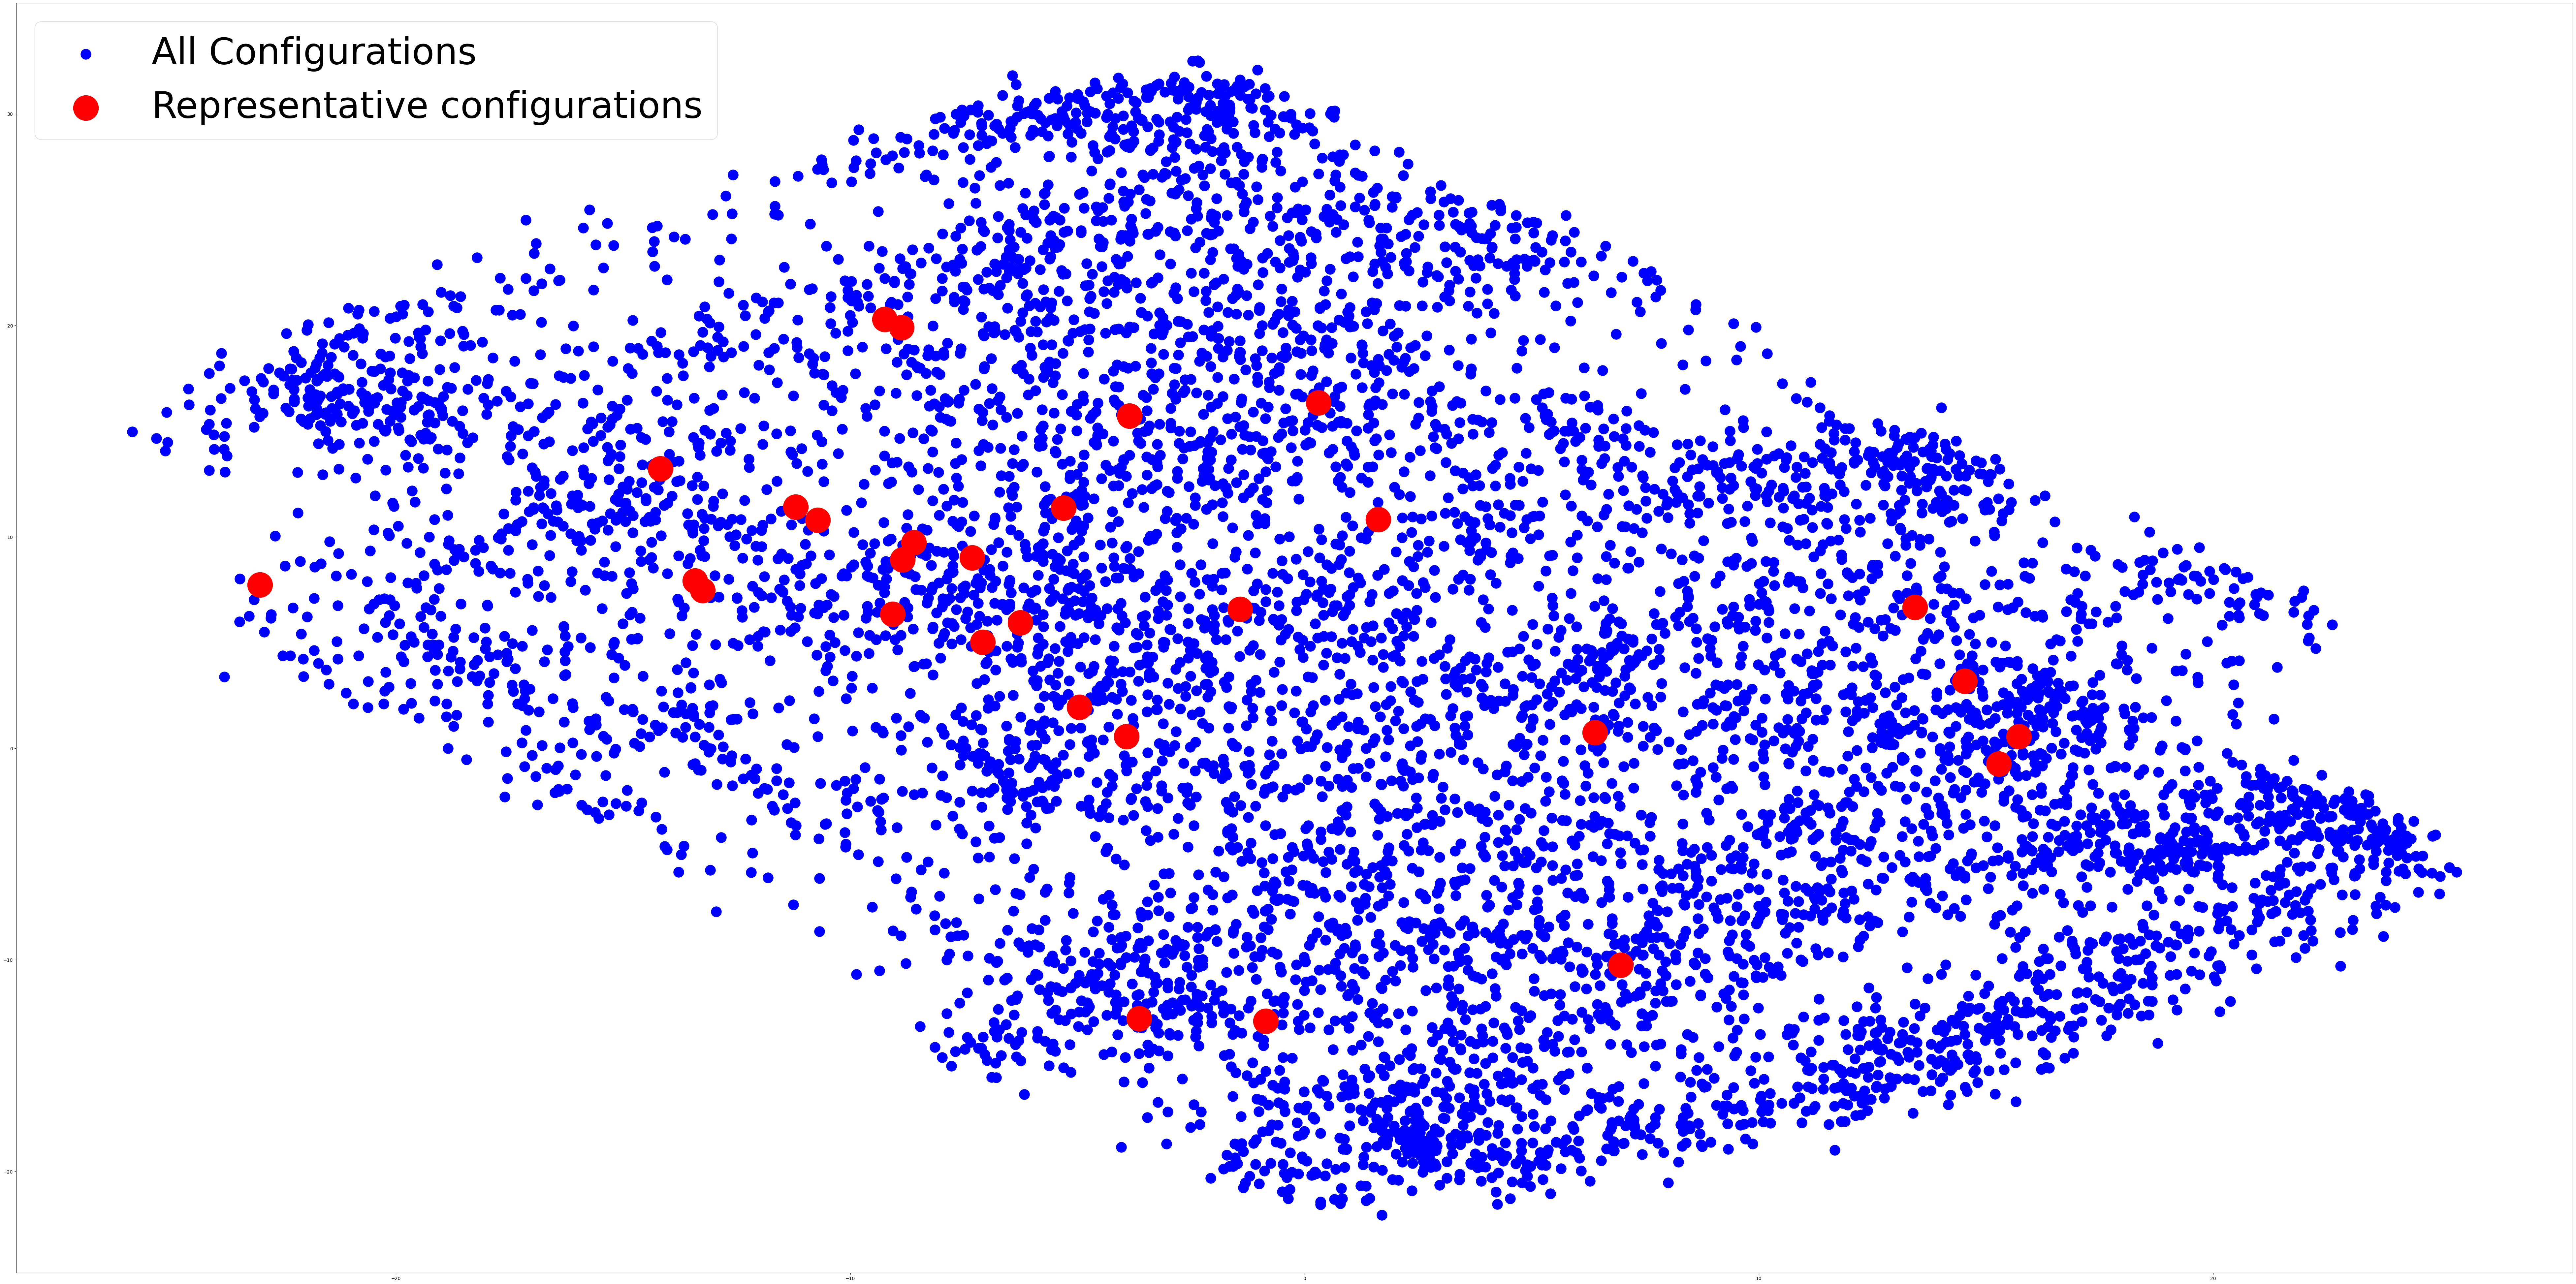

In [26]:
# visualize configurations in contrast to representative configurations

x = []
y = []
x1 = []
y1 = []
with open("visualization/2d_embedding", "r") as infile:
    for line in infile.readlines()[1:]:
        split_values = line.split()
        x.append(float(split_values[1]))
        y.append(float(split_values[2]))
with open("visualization/landmarks", "r") as infile:
    for line in infile.readlines()[1:]:
        split_values = line.split()
        x1.append(float(split_values[1]))
        y1.append(float(split_values[2]))
        
        
plt.figure(figsize=(100, 50), dpi=100)
plt.scatter(x, y, c='b', marker='.', label='All Configurations', s=2000)
plt.scatter(x1, y1, c='r', marker='o', label='Representative configurations', s=3000)
plt.legend(loc='upper left', prop={'size': 80})

plt.show()

## 4. Accurate energy computation

**Changed to xTB2 - BP86 - TPSSh - b2plyp** according to Martin Krupicka recommendations. **in progress**

**Accurate energy** values are computed in this step using the [Orca](https://sites.google.com/site/orcainputlibrary/) quantum chemistry software. Orca uses [method files](https://sites.google.com/site/orcainputlibrary/generalinput) in exact format to perform the computations. Computation of exact energy values of each representative is composed of 3-step chain. Input for *AM1* are representative configurations defined by clustering in previous step. Each next computation is performed on the output of the previous step.

1. **AM1 optimisation** (*input*: clustering results)
2. **BP86 SVP** (*input*: AM1 output)
3. **BP86 TZVP** (*input*: BP86 SVP output, *output*: exact energy values of representative configurations)

Also each step above consists of 3 substeps:

1. Convert the output of previous step to Orca compatible *.inp method*
2. Perform Orca computation
3. Analyse output (see logs)

You can view the current state of Orca calculation in output logs (3rd substep) with for example *\"tail -f XXX\"* command. Please read the wrapper [documentation](https://github.com/CERIT-SC/pmcvff-correction/tree/jupyter-refactor/modules/k8s) before interacting with any Orca command.

In [9]:
# initialize a list of all clusters that are considered
# in the quantum chemistry computations. For example
# non-converged simulation on cluster will result in
# discarding that cluster from further computations
#
# ** don't forget to reset clusters variable when
# rerunning computations as non-converged will be
# missing **
clusters = []
for cluster in os.listdir('clustering/outClustersPDB'):
    if '.pdb' in cluster:
        clusters.append(cluster.replace('.pdb', ''))
        

In [72]:
# convert .pdb file to orca method
# - method specifies which method to apply by Orca
# - info is to specify the *charge* and *spin* of molecule
# - nprocs is to specify the number of CPU's to use (None for default)
# - xyz specify True to convert .xyz to orca instead
def pdb2orca(pdb_in, orca_out, method, info, nprocs=8, xyz=False):
    with open(pdb_in, 'r') as infile, open(orca_out, 'w') as outfile:
        outfile.write(f'{method}\n')
        
        if nprocs:
            outfile.write(f'%pal\n' +
                          f'nprocs {str(nprocs)}\n' +
                          f'end\n')
            outfile.write(f'%maxcore {32 // nprocs}000\n')
            
        outfile.write('%geom\n' +
                      'Constraints\n')
        
        # write torsions
        for torsions_list in torsions:
            outfile.write('{D ' +
                          ' '.join(str(x) for x in torsions_list) +
                          'C}\n')
        
        outfile.write('end\n' + 
                      'end\n\n' +
                     f'*xyz {info[0]} {info[1]}\n')
        
        # copy atom information from input and modify
        # to fit the orca method format
        if xyz:
            for line in infile.readlines()[2:]:
                outfile.write(f'{line}')
        else:
            for line in infile.readlines():
                splitline = line.split()
                if splitline[0] == 'ATOM':
                    atom = splitline[10]
                    if atom == 'A': # auranofin
                        atom = 'Au'
                    else:
                        atom = atom + ' '
                    orca_line = f'{atom}      {splitline[5]}      {splitline[6]}       {splitline[7]}\n'
                    outfile.write(orca_line)
                
        outfile.write('*\n')

In [73]:
# XXX: quick hack: overriding functions from modules.k8s to fix some errors without rebuilding the image
# to be removed from here after it's fixed


import ruamel.yaml
from ruamel.yaml.scalarstring import DoubleQuotedScalarString
import subprocess
import time
import os
import sys
import pickle

from modules.k8s.config import Config

Config.ORCA_IMAGE = 'ljocha/orca:5.0.1'

def write_template(method, command, params, **kwargs):
        orca_method_file = kwargs.get('orca_method_file', '')
        timestamp = str(time.time()).replace(".", "")
        # Always replace "" with "-" because "" is not kubernetes accepted char in the name
        method = method.replace("_", "-")
        # Set default values
        default_image = ''
        default_name = ''

        template_file = "orca-k8s-template.yaml" if method == "orca" else "gmx-k8s-template.yaml"
        with open(template_file) as ifile:
                doc = ruamel.yaml.round_trip_load(ifile, preserve_quotes=True)

                if method == "orca":
                    default_image = Config.ORCA_IMAGE
                    default_name = "orca"
                    
                    # Set orca required cpus
                    no_of_procs = k8s_utils.get_no_of_procs(orca_method_file)
                    if no_of_procs != -1 and no_of_procs <= 12:
                        doc['spec']['template']['spec']['containers'][0]['resources']['requests']['cpu'] = no_of_procs
                    else:
                        doc['spec']['template']['spec']['containers'][0]['resources']['requests']['cpu'] = 12
                elif method == 'parmtsnecv':
                    default_image = Config.PARMTSNECV_IMAGE
                    default_name = 'parmtsnecv'
                else:
                    default_image = Config.GMX_IMAGE
                    default_name = 'gromacs'

                    double_env = {'name': "GMX_DOUBLE", 'value': DoubleQuotedScalarString("ON" if params["double"] else "OFF")}
                    rdtscp_env = {'name': "GMX_RDTSCP", 'value': DoubleQuotedScalarString("ON" if params["rdtscp"] else "OFF")}
                    arch_env = {'name': "GMX_ARCH", 'value': DoubleQuotedScalarString(params["arch"])}
                    doc['spec']['template']['spec']['containers'][0]['env'] = [double_env, rdtscp_env, arch_env]

                

                identificator = "{}-{}-rdtscp-{}".format(default_name, method, timestamp)
                # Set names
                doc['metadata']['name'] = identificator
                doc['spec']['template']['spec']['containers'][0]['name'] = "{}-{}-deployment-{}".format(default_name, method, timestamp)
                doc['spec']['template']['metadata']['labels']['app'] = identificator
                # Set gromacs/orca command
                doc['spec']['template']['spec']['containers'][0]['args'] = ["/bin/bash", "-c", DoubleQuotedScalarString(command)]
                # Set image
                doc['spec']['template']['spec']['containers'][0]['image'] = default_image if not params["image"] else params["image"]
                # Set working directory
                doc['spec']['template']['spec']['containers'][0]['workingDir'] = "/tmp/"
                if params["workdir"]:
                        doc['spec']['template']['spec']['containers'][0]['workingDir'] += params["workdir"]

                # set PVC
                pvc_name = f'claim-{os.environ["JUPYTERHUB_USER"]}'
                if len(pvc_name) == 0:
                        raise Exception("Error setting pvc_name, probably problem in setting env variable of actual container")
                doc['spec']['template']['spec']['volumes'][0]['persistentVolumeClaim']['claimName'] = pvc_name

                # If parallel is enabled set label so kubectl logs can print logs according to label
                if params["parallel"]:
                        with open(f"{Config.PICKLE_PATH}/lock.pkl","rb") as fp:
                                lock_object = pickle.load(fp)
                        if len(lock_object['Parallel_label']) == 0:
                                label = {"Parallel_label": identificator, "Count": 0}
                                with open(f"{Config.PICKLE_PATH}/lock.pkl","wb") as fp:
                                        pickle.dump(label, fp)
                        else:
                                doc['spec']['template']['metadata']['labels']['app'] = lock_object['Parallel_label']

                # Write to file
                ofile_name = "{}-{}-rdtscp.yaml".format(default_name, method)
                with open(ofile_name, "w") as ofile:
                        ruamel.yaml.round_trip_dump(doc, ofile, explicit_start=True)

                return ofile_name, identificator



In [75]:
import modules.k8s.k8s_utils as k8s_utils
def orca_run(orca_method, log, **kwargs):
        """
        Convert orca command into yaml file which is then run by kubernetes

        :param str orca_command: orca method used for computation
        :param str log: log file to store output of computation
        :kwargs str image: specify used image
        :kwargs str workdir: specify directory where should the calculation take place
        """

        params = {
                "image": kwargs.get('image', None),
                "workdir": kwargs.get('workdir', None),
                "parallel": kwargs.get('parallel', None)
        }

        log = f"/tmp/{log}"
        application = "orca"
        orca = "/opt/orca/{} {} > {}".format(application, orca_method, log)
        print(orca)
        method_path = "{}/{}".format(params['workdir'], orca_method)
        print(method_path)

#        kubernetes_config, label = k8s_utils.write_template(application, orca, params, orca_method_file=method_path)

        kubernetes_config, label = write_template(application, orca, params, orca_method_file=method_path)
        print(k8s_utils.run_job(kubernetes_config, label, params["parallel"]))
#       print(kubernetes_config)
#       print(label)



In [74]:
charge=Chem.rdmolops.GetFormalCharge(mol)
charge

0

In [76]:
# Try b2plyp directly


method = '!b2plyp RIJCOSX def2-tzvpp def2/J def2-tzvp/C Opt'


# input directory of .pdb representatives
input_dir = 'clustering/outClustersPDB/'

# output directory where converted .inp Orca 
# methods will be placed
output_dir = 'b2plyp/input/'
!mkdir -p {output_dir}

# specify spin (and charge)
spin = 1
# charge is specified in the first step 
# of 1. Molecule shape processing
# charge = XXX


for pdb in os.listdir(input_dir):
    if '.pdb' in pdb:
        infile = input_dir + pdb
        outfile = output_dir + pdb.replace('pdb', 'inp')

        pdb2orca(infile, outfile, method, (charge,spin))

In [11]:
input_path = "b2plyp/input/"
output_path = "b2plyp/output/"
!mkdir -p {output_path}

In [ ]:
for method_file in os.listdir(input_path):
    if '.inp' in method_file:
        log_file = method_file.replace('inp', 'out')
        cluster_dir = method_file.replace('.inp', '/')
        cluster_dir_path = output_path + cluster_dir

        if not os.path.exists(cluster_dir_path):
            os.mkdir(cluster_dir_path)    
        shutil.copy(input_path + method_file, cluster_dir_path)

        orca_run(method_file, cluster_dir_path + log_file, workdir=cluster_dir_path, parallel=True)
    
parallel_wait()

/opt/orca/orca outCluster20.inp > /tmp/b2plyp/output/outCluster20/outCluster20.out
b2plyp/output/outCluster20//outCluster20.inp
job.batch/orca-orca-rdtscp-16851170095740514 created
None
/opt/orca/orca outCluster11.inp > /tmp/b2plyp/output/outCluster11/outCluster11.out
b2plyp/output/outCluster11//outCluster11.inp
job.batch/orca-orca-rdtscp-16851170119318993 created
None
/opt/orca/orca outCluster7.inp > /tmp/b2plyp/output/outCluster7/outCluster7.out
b2plyp/output/outCluster7//outCluster7.inp
job.batch/orca-orca-rdtscp-1685117013633866 created
None
/opt/orca/orca outCluster26.inp > /tmp/b2plyp/output/outCluster26/outCluster26.out
b2plyp/output/outCluster26//outCluster26.inp
job.batch/orca-orca-rdtscp-1685117015008266 created
None
/opt/orca/orca outCluster2.inp > /tmp/b2plyp/output/outCluster2/outCluster2.out
b2plyp/output/outCluster2//outCluster2.inp
job.batch/orca-orca-rdtscp-16851170159695451 created
None
/opt/orca/orca outCluster17.inp > /tmp/b2plyp/output/outCluster17/outCluster17.out

Waiting for job(s) with label orca-orca-rdtscp-16851170095740514
Waiting for 29 jobs to complete
Using namespace mff-prod-ns


In [ ]:
# check output && discard non-converging clusters
number_of_clusters = len(clusters)

for cluster in clusters:
    log_file = f'{output_path}{cluster}/{cluster}.out'
    with open(log_file) as infile:
        log = infile.read()
        if '****ORCA TERMINATED NORMALLY****' not in log:
            !{orca_job_check} {log_file}
            clusters.remove(cluster)

print(f'''{len(clusters)}/{number_of_clusters} successfully converged - unconverged are not considered
           in next steps.\n You can view logs at "{output_path}" directory''')

In [16]:
# instead of previous cell, we may be interested in intermediate results

number_of_clusters = len(clusters)

for cluster in clusters:
    log_file = f'{output_path}{cluster}/{cluster}.out'
    try:
        with open(log_file) as infile:
            log = infile.read()
            if 'FINAL SINGLE POINT ENERGY' not in log:
                !{orca_job_check} {log_file}
                clusters.remove(cluster)
    except FileNotFoundError:
        clusters.remove(cluster)

clusters            

['outCluster11',
 'outCluster12',
 'outCluster8',
 'outCluster26',
 'outCluster4',
 'outCluster15',
 'outCluster1',
 'outCluster22',
 'outCluster17',
 'outCluster7',
 'outCluster20',
 'outCluster24',
 'outCluster23',
 'outCluster2',
 'outCluster27',
 'outCluster14',
 'outCluster18']

In [17]:
# extract final energies from output of Orca TZVP method
# note: energies are in hartree unit
orca_energies = {}

for cluster in clusters:
    with open(f'{output_path}{cluster}/{cluster}.out') as infile:
        for line in reversed(list(infile)):
            energy_list = re.findall(r'(FINAL SINGLE POINT ENERGY)( +)(-?\d+\.\d+)', line)
            if len(energy_list) > 0:
                orca_energies[cluster] = float(energy_list[0][2])
                break

In [18]:
# convert from hartree to kJ/mol

CONVERSION_CONST = 2625.499638
min_energy = min(list(orca_energies.values()))

for cluster, energy in orca_energies.items():
    orca_energies[cluster] = (energy-min_energy)*CONVERSION_CONST
    
orca_energies

{'outCluster11': 8.59025738733933,
 'outCluster12': 21.37990892940907,
 'outCluster8': 352.5826396459286,
 'outCluster26': 56.19611285873913,
 'outCluster4': 13.322411100455696,
 'outCluster15': 0.0,
 'outCluster1': 35.1602939508531,
 'outCluster22': 99.99590873653148,
 'outCluster17': 29.84600896256199,
 'outCluster7': 67.74622991454132,
 'outCluster20': 15.910550934496172,
 'outCluster24': 23.177356136004796,
 'outCluster23': 26.92110944118104,
 'outCluster2': 29.16100594583887,
 'outCluster27': 144.7391352797871,
 'outCluster14': 47.20687778861149,
 'outCluster18': 12.632784324504971}

## 5. Inaccurate energy computation
**Inaccurate energy** values are computed via Gromacs. To compute energy values we use structures whose geometry was optimised by Orca. Afterwards dihedrals are computed from optimised structures' trajectory by [Plumed](https://www.plumed.org/). Finally using dihedrals compute inaccurate energy values.

### 5.1 Convert optimised .xyz files to .pdb format
Convert optimised structures to corresponding *.pdb* files by combining information about atoms from cluster representative *.pdb* file and xyz coordinates from optimised *.xyz* file. 

In [19]:
#input_dir = 'bp86tzvp/output/'
input_dir = 'b2plyp/output/'
output_dir = 'pdb_opt/'

In [18]:
# get information about atoms from cluster representative
# (frist 26 columns - see .pdb format details for details)
atoms = []
with open('clustering/outClustersPDB/outCluster0.pdb', 'r') as infile:
    for line in infile.readlines():
            if "ATOM" in line:
                atoms.append(line[:26])

                
# combine atoms from .pdb with optimised coordinates from .xyz
for cluster in clusters:
    with open(f'{input_dir}{cluster}/{cluster}.xyz', 'r') as infile, \
         open(f'{output_dir}{cluster}_opt.pdb', 'w') as outfile:
        xyz = infile.readlines()[2:]
        for i in range(len(atoms)):
            split_line = xyz[i].split()
            
            # fix spaces near numbers with '-' to fit .pdb format
            # and print only 3 decimal places
            for j in range(1, len(split_line)):
                split_line[j] = f'{round(float(split_line[j]), 3):.3f}'
                if split_line[j][0] != '-':
                    split_line[j] = f' {split_line[j]}'
            pdb_line = f'{atoms[i]}     {split_line[1]}  {split_line[2]}  {split_line[3]}  1.00  0.00\n'
            outfile.write(pdb_line)

### 5.2 Compute dihedrals

In [ ]:
# concatinate optimised structures to a trajectory
# so it can be processed by Plumed
with open('clusters_opt.pdb', 'w') as outfile:
    for cluster in clusters:
        outfile.write(f'MODEL {cluster[len(cluster)-1]}\n')
        with open(f'pdb_opt/{cluster}_opt.pdb', 'r') as infile:
            outfile.write(infile.read())
            outfile.write('ENDMDL\n')


# create plumed file for Plumed processing
with open('plumed.dat', 'w') as infile:
    cvs = []
    infile.write(f'WHOLEMOLECULES ENTITY0=1-{str(natoms)}\n')
    for i in range(0, len(torsions)):
        cvs.append(f'cv{i}')
        delimeted_torsions = ','.join(str(x+1) for x in torsions[i])  # XXX +1 
        infile.write(f'TORSION ATOMS={delimeted_torsions} LABEL={cvs[i]}\n')
    cvs = ','.join(cvs)
    infile.write(f'PRINT ARG={cvs} STRIDE=1 FILE=DIHEDRALS')
    

# compute dihedrals (produces output file DIHEDRALS)
gmx_run(f'driver --plumed plumed.dat --mf_pdb clusters_opt.pdb')

In [31]:
# remove all # lines, keep only numbers
lines = []
with open("DIHEDRALS", "r") as ifile:
    for line in ifile.readlines():
        if "#" not in line:
            lines.append(line)
with open("DIHEDRALS", "w") as ofile:
    for line in lines:
        ofile.write(line)

### 5.3 Compute inaccurate energy values

In [20]:
cvs = [[] for _ in range(len(clusters))]
with open('DIHEDRALS','r') as infile:
    dihedrals = infile.readlines()
    for i in range(len(dihedrals)):
        t_angles = dihedrals[i].split()
        for j in range(len(torsions)):
            cvs[i].append(float(t_angles[j+1])*(180/math.pi))

            
def generate_restraint(cluster):
    wrote=False
#    with open('MOL.amb2gmx/MOL_GMX.top', 'r') as infile, \
    with open('auranofin.amb2gmx/auranofin_GMX.top', 'r') as infile, \
         open(f'gaff/{cluster}/restrained.top', "w") as outfile:
        for line in infile.readlines():
            if line == "; Ligand position restraints\n":
                outfile.write("\n")
                outfile.write("[ dihedral_restraints ]\n")
                for j in range(len(torsions)):
                    outfile.write(" ".join(map(lambda x: str(x+1),torsions[j])))  # XXX +1
                    outfile.write(" 2 %3.1f 0 500\n" %cvs[i][j])
                wrote=True
            outfile.write(line)
            
        if not wrote:
            outfile.write("\n")
            outfile.write("[ dihedral_restraints ]\n")

            for j in range(len(torsions)):
                outfile.write(" ".join(map(lambda x: str(x+1),torsions[j])))  # XXX +1
                outfile.write(" 2 %3.1f 0 500\n" %cvs[i][j])

            
            

In [44]:
!mkdir -p gaff/{clusters[0]}/
generate_restraint(clusters[0])

In [21]:
torsions

[(0, 1, 6, 7),
 (1, 6, 7, 9),
 (12, 9, 10, 43),
 (25, 13, 14, 15),
 (13, 14, 15, 16),
 (14, 15, 16, 17),
 (34, 25, 26, 27),
 (25, 26, 27, 28),
 (25, 34, 36, 37),
 (34, 36, 37, 42),
 (44, 48, 51, 59),
 (48, 51, 52, 53),
 (48, 51, 59, 62),
 (9, 10, 43, 51),
 (10, 43, 51, 52)]

In [22]:
            
# select groups for energy evaluation
# Group     0 (         System)
# Group     1 (          Other)
# Group     2 (            MOL)
# Group     3 (         Custom)
#groups = "10" XXX bond only???
groups = '90' # potential

for cluster in clusters:
    cluster_workdir = f'gaff/{cluster}'
    if not os.path.exists(cluster_workdir):
        os.mkdir(cluster_workdir)
        
    shutil.copy(f'pdb_opt/{cluster}_opt.pdb', cluster_workdir)
    shutil.copy('auranofin.amb2gmx/auranofin_GMX.top', cluster_workdir)
    shutil.copy('em/em.mdp', cluster_workdir)
    shutil.copy('md/md.mdp', cluster_workdir)
    generate_restraint(cluster)
    gmx_run(f'editconf -f {cluster}_opt.pdb -box 3 3 3 -bt cubic -c -o box.gro', workdir=cluster_workdir)
    gmx_run('grompp -f em -c box.gro -p restrained.top -o em1', workdir=cluster_workdir)
    gmx_run('mdrun  -s em1 -c after_em1 -g em1 -e em1 -o em1', workdir=cluster_workdir)
    gmx_run('grompp -f md -c box.gro -p auranofin_GMX.top -o rerun', workdir=cluster_workdir)
    gmx_run('mdrun  -s rerun -rerun em1 -c after_rerun -g rerun -e rerun -o rerun', workdir=cluster_workdir)
    gmx_run('energy -f rerun.edr -o rerun.xvg', workdir=cluster_workdir, groups=groups)

job.batch/gromacs-editconf-rdtscp-16853509357468874 created


Waiting for job(s) with label gromacs-editconf-rdtscp-16853509357468874
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16853509467124286
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16853509605799723
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16853509721088731
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16853509815063615
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-16853509945085258
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-16853511013562887
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16853511108996236
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-1685351122702061
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-1685351132123533
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16853511411089559
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-16853511499994652
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-16853511608382294
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-1685351170307216
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-1685351179407839
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16853511880033343
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16853511969993527
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-16853512056647959
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-16853512152318702
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-168535122420864
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-1685351234399613
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16853512437052598
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-1685351252602609
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-16853512616035676
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-16853512704320776
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16853512795026658
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16853512878146315
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16853513021356196
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16853513117080178
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-16853513208065794
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-1685351332162382
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16853513406039393
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-1685351349699314
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16853513610071099
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-1685351370404547
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-1685351379646837
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-16853513888595006
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16853513976079986
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16853514070992455
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-1685351415899085
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16853514248081408
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-1685351433905934
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-16853514451570275
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16853514551103585
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16853514644035342
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-1685351473705528
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16853514825406153
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-1685351491508406
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-16853515032708402
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16853515122995157
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16853515217075934
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16853515353073404
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16853515444109056
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-16853515534047635
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-1685351562939739
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16853515724064074
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16853515810991921
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16853515994996974
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16853516081038892
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-1685351616801925
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-16853516262255259
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16853516349345536
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-1685351644001717
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16853516528230813
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-1685351661504866
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-16853516705105133
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-16853516795723429
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16853516888032062
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-1685351698309994
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16853517079065218
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-1685351717699622
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-16853517268051333
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-16853517383356636
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16853517466049433
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16853517557316618
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16853517651053274
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-1685351775212368
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-16853517854089634
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-16853517964777546
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-1685351806309627
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-1685351817515558
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16853518296076233
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16853518391067677
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-16853518482076933
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-1685351860367137
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16853518693086936
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-1685351879607677
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16853519031088188
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16853519133060164
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-16853519229985673
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-16853519357961984
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16853519456093118
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16853519554041295
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-16853519654070814
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16853519752083075
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-16853519850114055
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-editconf-rdtscp-168535199731156
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-grompp-rdtscp-16853520090155818
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-16853520182105632
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-grompp-rdtscp-1685352032305879
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-mdrun-rdtscp-1685352042412045
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

Waiting for job(s) with label gromacs-energy-rdtscp-16853520519086125
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx energy, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

In [36]:
# extract gaff energies and from each energy value 
# subtract minimal energy

gaff_energies = {}

for cluster in clusters:
    with open(f'gaff/{cluster}/rerun.xvg', 'r') as infile:
        last_line = infile.readlines()[-1]
        energies = last_line.split(' ')
        gaff_energies[cluster] = energies[len(energies) - 1].rstrip()

        
min_energy = min(map(lambda e: float(e), list(gaff_energies.values())))

for cluster, energy in gaff_energies.items():
    gaff_energies[cluster] = float(energy) - float(min_energy)
    
gaff_energies

{'outCluster11': 1962.906875,
 'outCluster12': 1320.348037,
 'outCluster8': 1766.802993,
 'outCluster26': 885.243545,
 'outCluster4': 680.751907,
 'outCluster15': 682.627334,
 'outCluster1': 741.457229,
 'outCluster22': 912.0929100000001,
 'outCluster17': 13.167816000000016,
 'outCluster7': 552.935501,
 'outCluster20': 1610.843277,
 'outCluster24': 611.733535,
 'outCluster23': 488.26771499999995,
 'outCluster2': 1107.932876,
 'outCluster27': 39.378615999999994,
 'outCluster14': 1152.737808,
 'outCluster18': 0.0}

In [35]:
min_energy

196.902695

## 6. Define correction of force field

In [24]:
# write corrected energy to final refernce.pdb file 

with open('reference.pdb', 'w') as outfile:
    for cluster in clusters:
        corrected_energy = orca_energies[cluster] - gaff_energies[cluster]
        outfile.write(f'REMARK X={corrected_energy}\n')
        with open(f'pdb_opt/{cluster}_opt.pdb', 'r') as infile:
            outfile.writelines(infile.readlines())

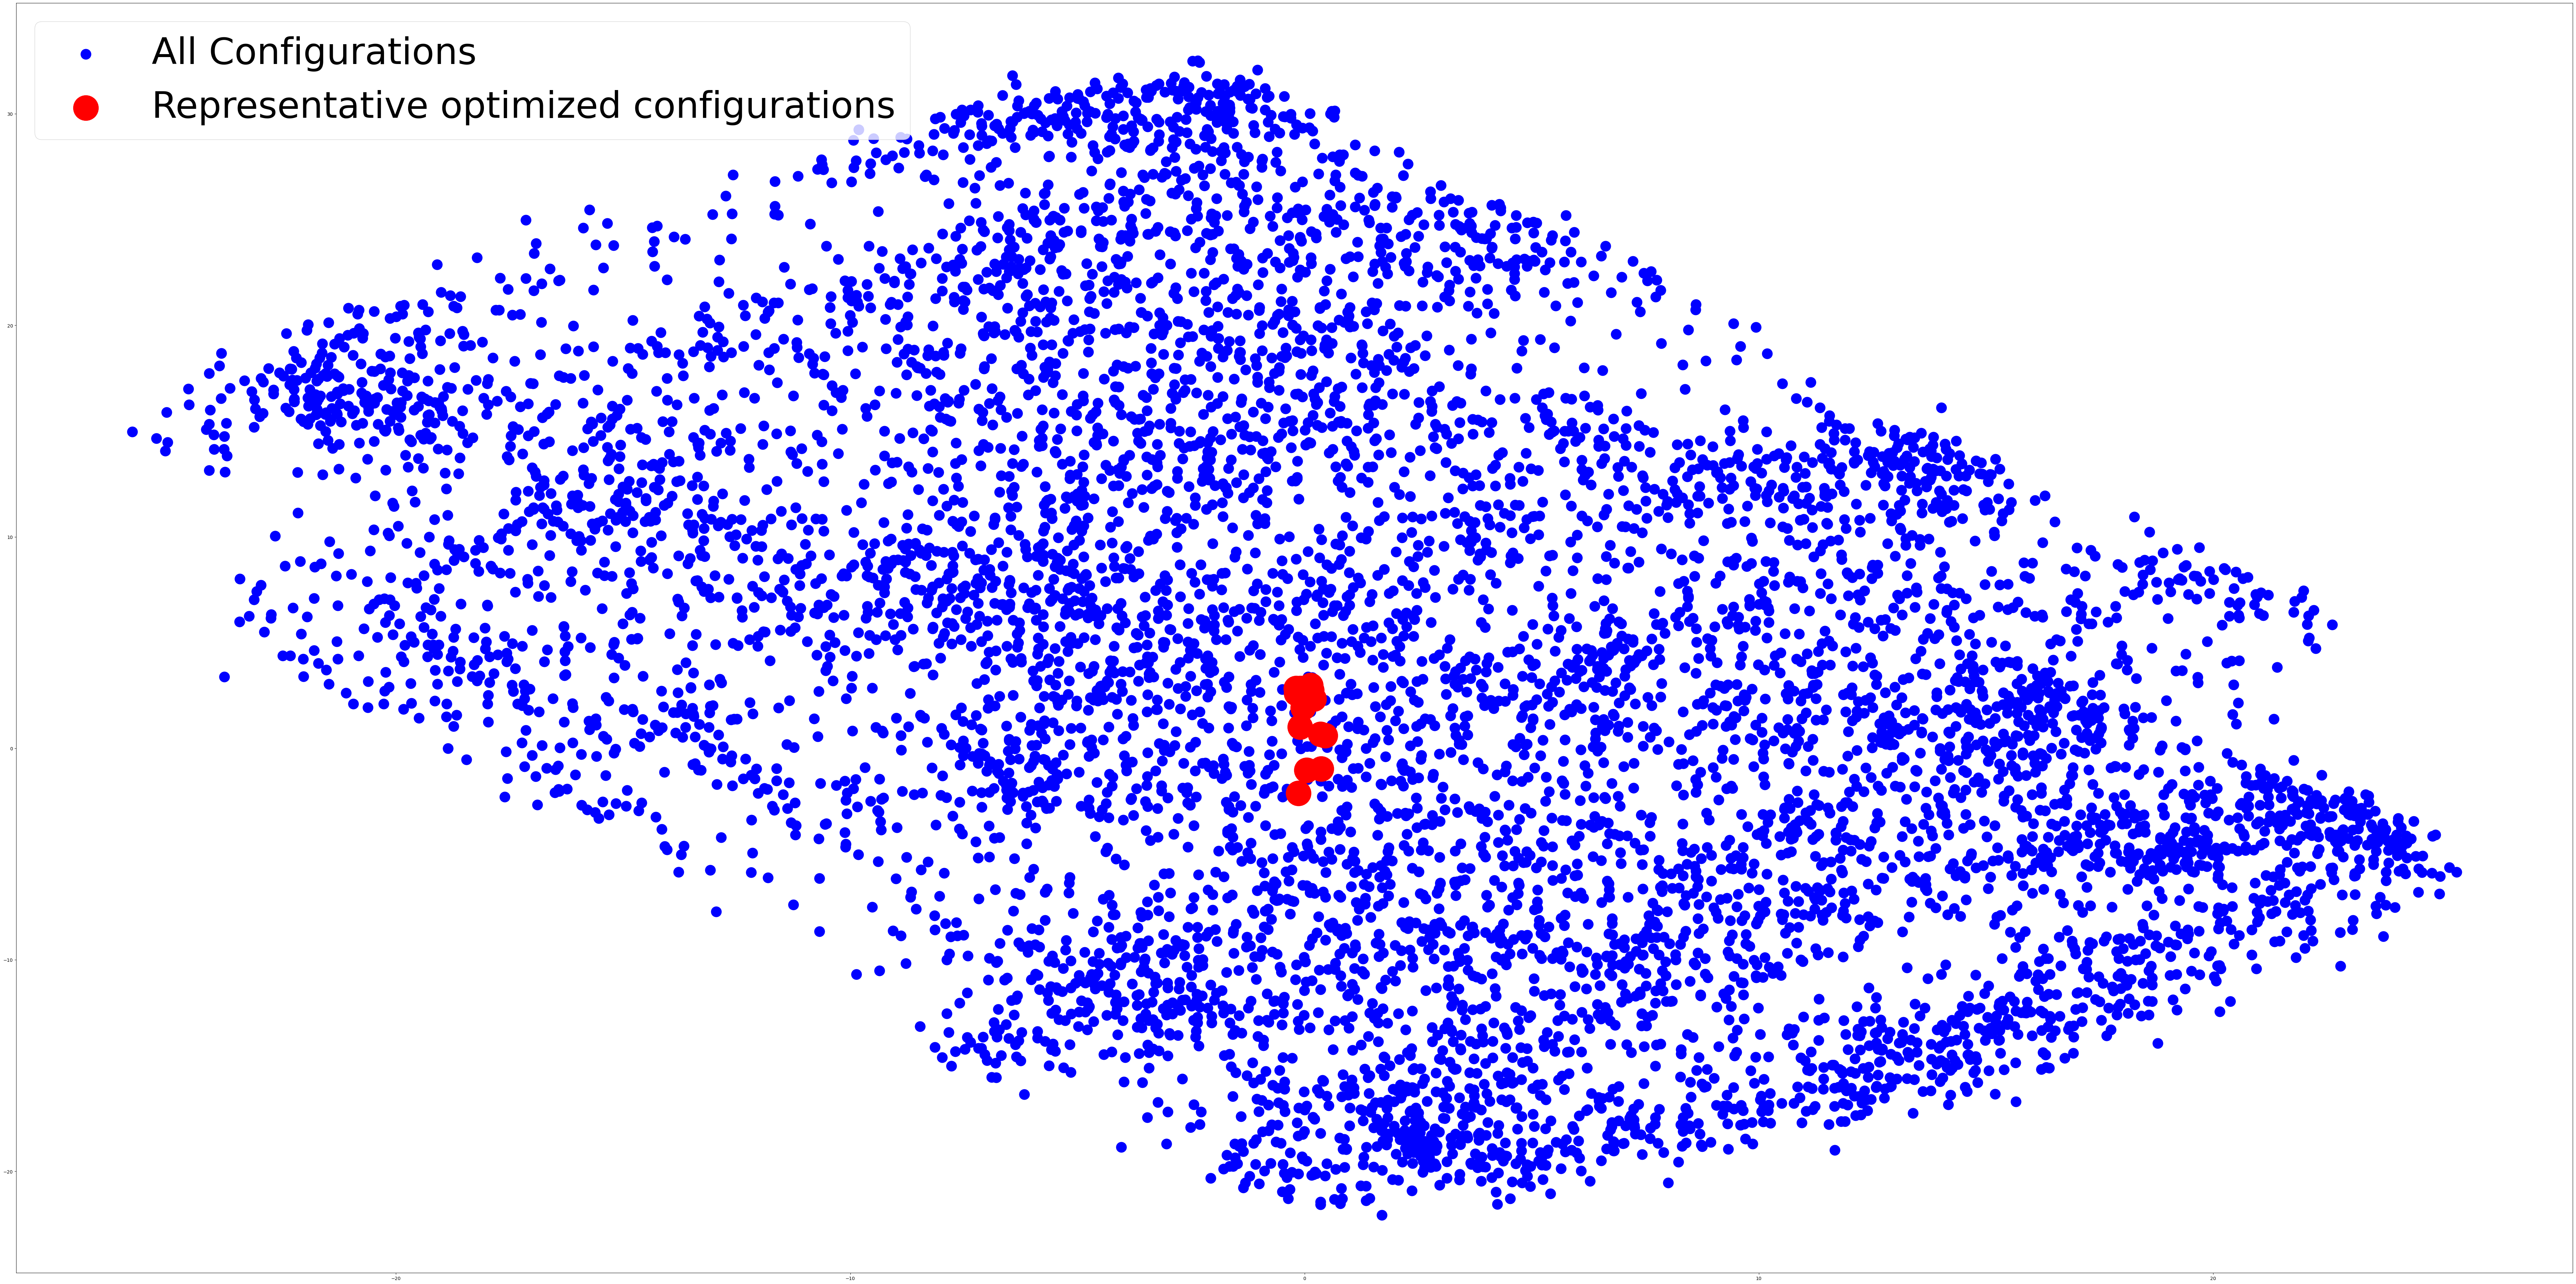

In [27]:
# visualize final result of correction

x1 = []
y1 = []

with open("DIHEDRALS") as ifile:
    for line in ifile.readlines():
        split_values = line.split()
        x1.append(float(split_values[1]))
        y1.append(float(split_values[2]))

plt.figure(figsize=(100, 50), dpi=100)
plt.scatter(x, y, c='b', marker='.', label='All Configurations', s=2000)
plt.scatter(x1, y1, c='r', marker='o', label='Representative optimized configurations', s=3000)
plt.legend(loc='upper left', prop={'size': 80})

plt.show()

In [28]:
clusters

['outCluster11',
 'outCluster12',
 'outCluster8',
 'outCluster26',
 'outCluster4',
 'outCluster15',
 'outCluster1',
 'outCluster22',
 'outCluster17',
 'outCluster7',
 'outCluster20',
 'outCluster24',
 'outCluster23',
 'outCluster2',
 'outCluster27',
 'outCluster14',
 'outCluster18']

In [24]:
# aux cleanup: kill some orca jobs to release resources

!for j in $(kubectl get jobs | grep orca-orca-rdtscp- | awk '{print $1}'); do \
    if kubectl get pod -l job-name=$j 2>&1 | grep 'No resources'; then \
        kubectl delete job/$j; \
    fi \
done

No resources found in mff-prod-ns namespace.
job.batch "orca-orca-rdtscp-16851170323497438" deleted
No resources found in mff-prod-ns namespace.
job.batch "orca-orca-rdtscp-16851170354699228" deleted
No resources found in mff-prod-ns namespace.
job.batch "orca-orca-rdtscp-16851170372112455" deleted
No resources found in mff-prod-ns namespace.
job.batch "orca-orca-rdtscp-16851170391338108" deleted
No resources found in mff-prod-ns namespace.
job.batch "orca-orca-rdtscp-16851170407248456" deleted
No resources found in mff-prod-ns namespace.
job.batch "orca-orca-rdtscp-1685117042609036" deleted
No resources found in mff-prod-ns namespace.
job.batch "orca-orca-rdtscp-16851170438045576" deleted
No resources found in mff-prod-ns namespace.
job.batch "orca-orca-rdtscp-1685117045548054" deleted
No resources found in mff-prod-ns namespace.
job.batch "orca-orca-rdtscp-16851170469730773" deleted
No resources found in mff-prod-ns namespace.
job.batch "orca-orca-rdtscp-16851170485184512" deleted
No

In [26]:
! for j in $(kubectl get jobs | grep orca-orca-rdtscp- | awk '{print $1}'); do \
    if kubectl describe job/$j 2>/dev/null | fgrep Cluster8. >/dev/null; then \
        echo $j; \
    fi; done

orca-orca-rdtscp-1685117034027553


In [27]:
!kubectl describe job/orca-orca-rdtscp-1685117034027553

Name:             orca-orca-rdtscp-1685117034027553
Namespace:        mff-prod-ns
Selector:         controller-uid=524beee9-c5bb-460d-a5d9-68fcfae78bfa
Labels:           app=orca-orca-rdtscp-16851170095740514
                  controller-uid=524beee9-c5bb-460d-a5d9-68fcfae78bfa
                  job-name=orca-orca-rdtscp-1685117034027553
Annotations:      batch.kubernetes.io/job-tracking: 
Parallelism:      1
Completions:      1
Completion Mode:  NonIndexed
Start Time:       Fri, 26 May 2023 16:03:55 +0000
Pods Statuses:    1 Active (1 Ready) / 0 Succeeded / 0 Failed
Pod Template:
  Labels:  app=orca-orca-rdtscp-16851170095740514
           controller-uid=524beee9-c5bb-460d-a5d9-68fcfae78bfa
           job-name=orca-orca-rdtscp-1685117034027553
  Containers:
   orca-orca-deployment-1685117034027553:
    Image:      ljocha/orca:5.0.1
    Port:       <none>
    Host Port:  <none>
    Args:
      /bin/bash
      -c
      /opt/orca/orca outCluster8.inp > /tmp/b2plyp/output/outCluster8/outC

In [28]:
!kubectl delete job/orca-orca-rdtscp-1685117034027553

job.batch "orca-orca-rdtscp-1685117034027553" deleted
